#Time Series Forecasting with Bitcoin

With data from [Coindesk](https://www.coindesk.com/price/bitcoin).

In [1]:
# Get access to GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4aba6971-ce2f-4a8d-1baf-0990fc84fb03)


In [2]:
# Import dependencies
import tensorflow as tf
import numpy as np
import pandas as pd
import io, os, zipfile, datetime
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Explore the data


In [3]:
local_file = files.upload()

Saving BTC_USD_2014-11-02_2022-08-29-CoinDesk.csv to BTC_USD_2014-11-02_2022-08-29-CoinDesk.csv


In [4]:
# Import time series with pandas
df = pd.read_csv("/content/BTC_USD_2014-11-02_2022-08-29-CoinDesk.csv",
                 parse_dates=["Date"], # Parse dates and set date column to index 
                 index_col=["Date"])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-11-02,326.075012,329.049988,320.626007,325.891998,325.891998,8603620
2014-11-03,325.569000,334.002014,325.480988,327.553986,327.553986,12948500
2014-11-04,327.161011,331.766998,325.076996,330.492004,330.492004,15655500
2014-11-05,330.683014,343.368988,330.683014,339.485992,339.485992,19817200
2014-11-06,339.458008,352.966003,338.424011,349.290009,349.290009,18797000


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-25,21395.458984,21789.636719,21362.441406,21600.904297,21600.904297,31028679593
2022-08-26,21596.085938,21804.908203,20199.482422,20260.019531,20260.019531,42326789564
2022-08-27,20262.480469,20340.775391,19890.523438,20041.738281,20041.738281,30116729776
2022-08-28,20041.035156,20139.054688,19616.814453,19616.814453,19616.814453,24366810591
2022-08-29,19629.597656,19910.044922,19610.013672,19835.164063,19835.164063,28003713024


In [6]:
# View info 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2858 entries, 2014-11-02 to 2022-08-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2858 non-null   float64
 1   High       2858 non-null   float64
 2   Low        2858 non-null   float64
 3   Close      2858 non-null   float64
 4   Adj Close  2858 non-null   float64
 5   Volume     2858 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 156.3 KB


In [7]:
# Samples size of days
len(df)

2858

In [8]:
# Train on dayly closing price
bitcoin_prices = pd.DataFrame(df["Adj Close"]).rename(columns={"Adj Close":"Price"})
bitcoin_prices.head()

,Price
Date,
2014-11-02,325.891998
2014-11-03,327.553986
2014-11-04,330.492004
2014-11-05,339.485992
2014-11-06,349.290009


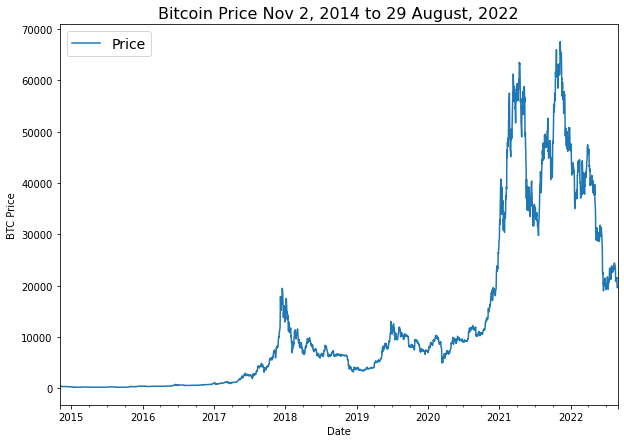

In [9]:
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Bitcoin Price Nov 2, 2014 to 29 August, 2022", fontsize=16)
plt.legend(fontsize=14);

##Create train and test sets

In [10]:
# Create bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2014-11-02T00:00:00.000000000', '2014-11-03T00:00:00.000000000',
        '2014-11-04T00:00:00.000000000', '2014-11-05T00:00:00.000000000',
        '2014-11-06T00:00:00.000000000', '2014-11-07T00:00:00.000000000',
        '2014-11-08T00:00:00.000000000', '2014-11-09T00:00:00.000000000',
        '2014-11-10T00:00:00.000000000', '2014-11-11T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([325.891998, 327.553986, 330.492004, 339.485992, 349.290009,
        342.415009, 345.488007, 363.264008, 366.924011, 367.695007]))

In [11]:
split_size = int(0.8*len(prices))

# Create train splits
X_train, y_train = timesteps[:split_size], prices[:split_size] 

# Create test splits
X_test, y_test = timesteps[split_size:], prices[split_size:] 

len(X_train), len(X_test), len(y_train), len(y_test)

(2286, 572, 2286, 572)

##Create a plotting function

In [12]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label) # Array of timesteps and values across time
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

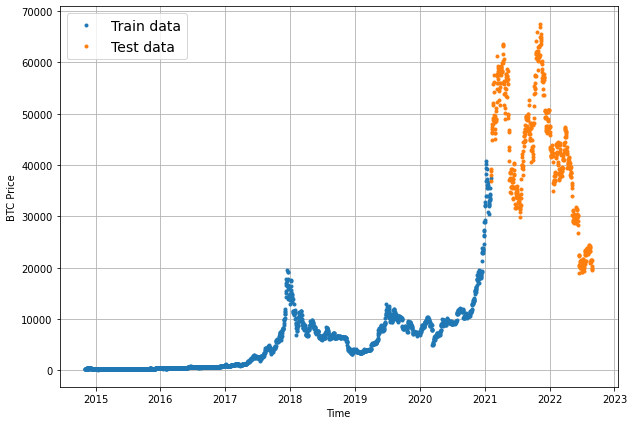

In [13]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

#Naive forecast 


In [14]:
# Create a naive forecast: Predicting previous timestep as next timestep 
naive_forecast = y_test[:-1]
naive_forecast[:5], naive_forecast[4:10]

(array([36926.066406, 38144.308594, 39266.011719, 38903.441406,
        46196.464844]),
 array([46196.464844, 46481.105469, 44918.183594, 47909.332031,
        47504.851563, 47105.515625]))

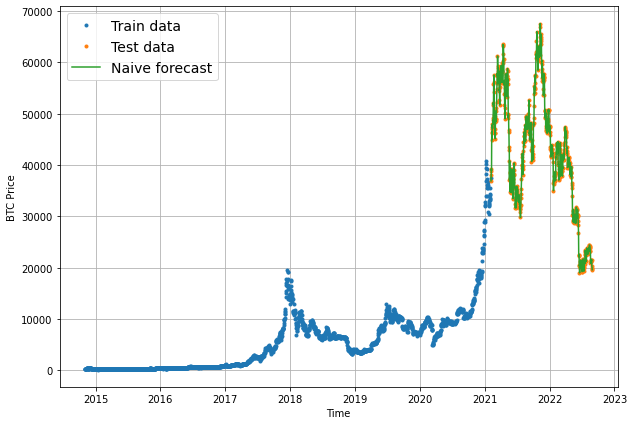

In [15]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

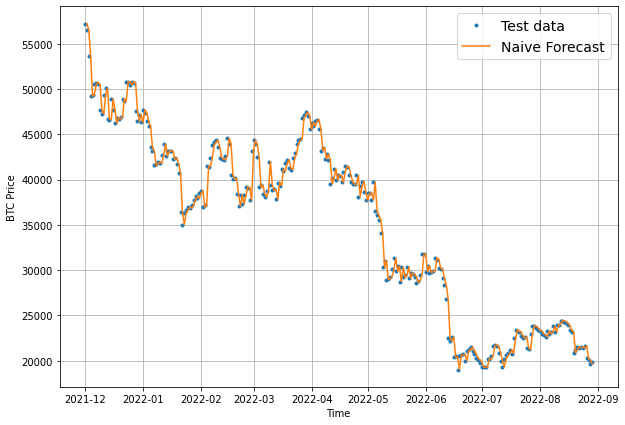

In [16]:
# Plot tail
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, start=300, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=300, format="-", label="Naive Forecast")# First index offset by 1

##Create metrics

In [17]:
# MASE (mean absolute scaled error) from Scikit-Learn for time series (t.ly/u_DQ)
def mase(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))
  mae_naive = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # Seasonality shift of 1 day
  mase = mae/mae_naive
  return mase

In [18]:
# Test MASE (well performing predictions get MASE of <1)
mase(y_true=y_test[1:], y_pred=naive_forecast).numpy()

1.0000764948926137

In [19]:
def calculate_metrics(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32) # float32 for metric tensors 
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred) # mean absolute error
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # mean squared error (Emphasise outliers by squaring errors)
  rmse = tf.sqrt(mse) # root mean square error
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred) # mean absolute percentage error
  mean_absolute_scaled_error = mase(y_true, y_pred)

  return {"mae": mae.numpy(), # Return as tensor dtype
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mean_absolute_scaled_error.numpy()}

In [20]:
naive_results = calculate_metrics(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 1167.3472,
 'mse': 2708600.8,
 'rmse': 1645.7827,
 'mape': 2.7939985,
 'mase': 1.0000763}

In [21]:
# Average, minimum and maximum bitcoin price in test set
tf.reduce_mean(y_test).numpy(), tf.reduce_min(y_test).numpy(), tf.reduce_max(y_test).numpy()

(42177.357261487756, 19017.642578, 67566.828125)

# Windowing datasets

In [22]:
# Windowing bitcoin into a supervised learning problem of one week
print(f"First 7 days: {prices[:7]} to predict day 8: {prices[7]}") 
print(f"Shift by one day: {prices[1:8]} to predict day 9: {prices[8]}") 
print(f"Shift by one day: {prices[2:9]} to predict day 10: {prices[9]}")

First 7 days: [325.891998 327.553986 330.492004 339.485992 349.290009 342.415009
 345.488007] to predict day 8: 363.264008
Shift by one day: [327.553986 330.492004 339.485992 349.290009 342.415009 345.488007
 363.264008] to predict day 9: 366.924011
Shift by one day: [330.492004 339.485992 349.290009 342.415009 345.488007 363.264008
 366.924011] to predict day 10: 367.695007


In [23]:
# Global variables for window and horizon size
WINDOW_SIZE = 7 # 7 days to predict next day
HORIZON = 1 # predict next day

In [24]:
# Creates labels for windowed dataset: For horizon of 1->[1, 2, 3, 4, 5, 6, 7] returns->([1, 2, 3, 4, 5, 6], [7])
def create_window_labels(x, horizon=HORIZON):
  return x[:, :-horizon], x[:, -horizon:] # Get all rows up to -1 index (window), and return -1 index (horizon/label) as tupple 

In [25]:
# Test window labelling function
test_window, test_label = create_window_labels(tf.expand_dims(tf.range(8)+1, axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [26]:
# Function to turn 1D arrays into 2D arrays of sequentially labelled windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON): # x is the time series

  # Create a window of window size and append horizon for later labelling
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # Create a 2D array of multiple window steps (account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 
  
  # Index the time series with a 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # Get the labelled windows
  windows, labels = create_window_labels(windowed_array, horizon=horizon)
  return windows, labels

In [27]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)# Full prices array (all data)
len(full_windows), len(full_labels)

(2851, 2851)

In [28]:
# Test the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [325.891998 327.553986 330.492004 339.485992 349.290009 342.415009
 345.488007] -> Label: [363.264008]
Window: [327.553986 330.492004 339.485992 349.290009 342.415009 345.488007
 363.264008] -> Label: [366.924011]
Window: [330.492004 339.485992 349.290009 342.415009 345.488007 363.264008
 366.924011] -> Label: [367.695007]


In [29]:
# Test the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [21166.060547 21534.121094 21398.908203 21528.087891 21395.019531
 21600.904297 20260.019531] -> Label: [20041.738281]
Window: [21534.121094 21398.908203 21528.087891 21395.019531 21600.904297
 20260.019531 20041.738281] -> Label: [19616.814453]
Window: [21398.908203 21528.087891 21395.019531 21600.904297 20260.019531
 20041.738281 19616.814453] -> Label: [19835.164063]


In [30]:
# The last label is the last value in the prices array
prices[-1]

19835.164063

##Create training and testing windows function

In [31]:
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  
  return train_windows, test_windows, train_labels, test_labels

In [32]:
# Create train and test windows 
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2280, 571, 2280, 571)

In [33]:
train_windows[:5], train_labels[:5]

(array([[325.891998, 327.553986, 330.492004, 339.485992, 349.290009,
         342.415009, 345.488007],
        [327.553986, 330.492004, 339.485992, 349.290009, 342.415009,
         345.488007, 363.264008],
        [330.492004, 339.485992, 349.290009, 342.415009, 345.488007,
         363.264008, 366.924011],
        [339.485992, 349.290009, 342.415009, 345.488007, 363.264008,
         366.924011, 367.695007],
        [349.290009, 342.415009, 345.488007, 363.264008, 366.924011,
         367.695007, 423.561005]]), array([[363.264008],
        [366.924011],
        [367.695007],
        [423.561005],
        [420.734985]]))

In [34]:
test_windows[:5], test_labels[:5]

(array([[34316.386719, 34269.523438, 33114.359375, 33537.175781,
         35510.289063, 37472.089844, 36926.066406],
        [34269.523438, 33114.359375, 33537.175781, 35510.289063,
         37472.089844, 36926.066406, 38144.308594],
        [33114.359375, 33537.175781, 35510.289063, 37472.089844,
         36926.066406, 38144.308594, 39266.011719],
        [33537.175781, 35510.289063, 37472.089844, 36926.066406,
         38144.308594, 39266.011719, 38903.441406],
        [35510.289063, 37472.089844, 36926.066406, 38144.308594,
         39266.011719, 38903.441406, 46196.464844]]), array([[38144.308594],
        [39266.011719],
        [38903.441406],
        [46196.464844],
        [46481.105469]]))

In [35]:
# Test if train labels are equal before and after window split
np.array_equal(np.squeeze(train_labels[:-HORIZON]), y_train[WINDOW_SIZE:])

True

##Create checkpoint callback

In [36]:
def model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # combine model_experiments w/model_name path
                                            verbose=0, save_best_only=True)

#Dense model (window=7, horizon=1)

In [37]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Build the model
dense_nn = tf.keras.Sequential([layers.Dense(128, activation='relu'),
                               layers.Dense(HORIZON, activation='linear') # Predicting a number (regression) is the same no activation  
                               ], name="dense_nn")

# Compile the model
dense_nn.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=['mae', 'mse'])

# Fit the model
dense_nn.fit(train_windows, train_labels, epochs=100, # Adjust epoch size to small data size
            verbose=1, batch_size=128, # Adjust batch size to small data size
            validation_data=(test_windows, test_labels),
            callbacks=[model_checkpoint(model_name=dense_nn.name)])# Use name attribute variable from model

Epoch 1/100
18/18 [==============================] - 3s 40ms/step - loss: 1320.8784 - mae: 1320.8784 - mse: 5719591.5000 - val_loss: 5688.6953 - val_mae: 5688.6953 - val_mse: 41863532.0000
Epoch 2/100
18/18 [==============================] - 0s 25ms/step - loss: 409.1548 - mae: 409.1548 - mse: 674700.1250 - val_loss: 2320.5093 - val_mae: 2320.5093 - val_mse: 9269025.0000
Epoch 3/100
18/18 [==============================] - 0s 26ms/step - loss: 291.3893 - mae: 291.3893 - mse: 385909.4688 - val_loss: 1958.9150 - val_mae: 1958.9150 - val_mse: 6788957.5000
Epoch 4/100
18/18 [==============================] - 0s 25ms/step - loss: 272.3750 - mae: 272.3750 - mse: 358776.0938 - val_loss: 1919.2218 - val_mae: 1919.2218 - val_mse: 6509057.0000
Epoch 5/100
18/18 [==============================] - 0s 25ms/step - loss: 263.5711 - mae: 263.5711 - mse: 342000.2188 - val_loss: 1828.1661 - val_mae: 1828.1661 - val_mse: 5878190.5000
Epoch 6/100
18/18 [==============================] - 0s 25ms/step - los

In [38]:
# Check evaluation
dense_nn.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1254.7139 - mae: 1254.7139 - mse: 2998108.2500


[1254.7138671875, 1254.7138671875, 2998108.25]

In [39]:
# Load best performing saved dense_nn and evaluate it on test data
dense_nn = tf.keras.models.load_model('model_experiments/dense_nn/')
dense_nn.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1182.6348 - mae: 1182.6348 - mse: 2747717.7500


[1182.634765625, 1182.634765625, 2747717.75]

In [40]:
# Recall naive results
naive_results

{'mae': 1167.3472,
 'mse': 2708600.8,
 'rmse': 1645.7827,
 'mape': 2.7939985,
 'mase': 1.0000763}

##Create prediction function for test set

In [41]:
def make_preds(model, input_data): # Takes a trained model and test data
  forecast = model.predict(input_data) # Forecast 'psuedo' future
  return  tf.squeeze(forecast) # returns 1D array of predictions

In [42]:
# Make predictions using dense_nn on the test data
dense_preds = make_preds(dense_nn, test_windows) 
len(dense_preds), dense_preds[:10]

18/18 [==============================] - 0s 1ms/step


(571, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([37075.473, 38048.867, 39296.09 , 39211.727, 45087.406, 46680.92 ,
        45389.297, 47404.68 , 48221.812, 47261.582], dtype=float32)>)

In [43]:
# Calculate metrics
dense_results = calculate_metrics(y_true=tf.squeeze(test_labels), # Remove extra dimentions on test labels
                                   y_pred=dense_preds)
dense_results

{'mae': 1182.635,
 'mse': 2747718.2,
 'rmse': 1657.6243,
 'mape': 2.8433785,
 'mase': 1.0131736}

In [44]:
# Recall naive results
naive_results

{'mae': 1167.3472,
 'mse': 2708600.8,
 'rmse': 1645.7827,
 'mape': 2.7939985,
 'mase': 1.0000763}

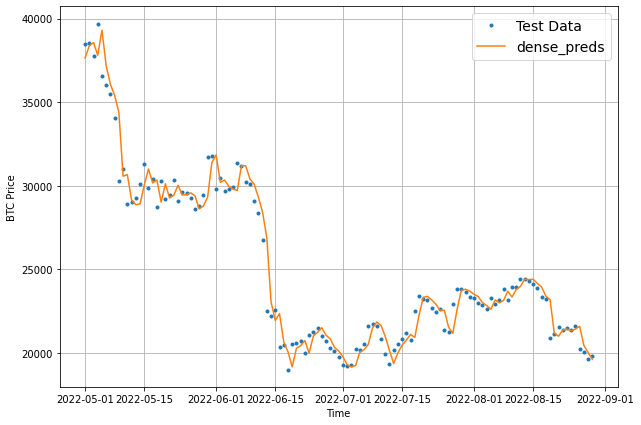

In [45]:
# Plot dense_nn predictions
offset = 450 # Zoom in on plot
plt.figure(figsize=(10, 7))

# Get every row, and zeroth dim-> values=test_labels[:, 0]
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset,  label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):], values=dense_preds, start=offset, format="-", label="dense_preds")

#Dense model (window = 30, horizon = 1)

In [46]:
HORIZON = 1
WINDOW_SIZE = 30

In [47]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2828, 2828)

In [48]:
# Create train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2262, 566, 2262, 566)

In [49]:
# Windows size of 30, label size of 1
train_windows[:1], train_labels[:1]

(array([[325.891998, 327.553986, 330.492004, 339.485992, 349.290009,
         342.415009, 345.488007, 363.264008, 366.924011, 367.695007,
         423.561005, 420.734985, 397.817993, 376.132996, 387.881989,
         387.40799 , 375.197998, 380.554993, 357.839996, 350.847992,
         352.920013, 367.572998, 376.901001, 375.347992, 368.369995,
         369.670013, 376.446991, 375.490997, 378.046997, 379.244995]]),
 array([[381.315002]]))

In [50]:
tf.random.set_seed(42)

# Create the model (sequential)
dense_nn2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)], name="dense_nn2")

# Compile the model
dense_nn2.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())

# Fit the model
dense_nn2.fit(train_windows, train_labels, epochs=100, batch_size=128, verbose=0, validation_data=(test_windows, test_labels),
              callbacks=[model_checkpoint(model_name=dense_nn2.name)])

In [51]:
# Evaluate dense_nn2 on the test set
dense_nn2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1255.3810


1255.3809814453125

In [52]:
# Load in the best performing dense_nn2 model
dense_nn2 = tf.keras.models.load_model('model_experiments/dense_nn2/')
dense_nn2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1255.3810


1255.3809814453125

In [53]:
# Get dense_nn2 predictions/pseudo forecast
dense_preds2 = make_preds(dense_nn2, input_data=test_windows)
dense_preds2[0]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=47179.805>

In [54]:
# Calculate metrics for dense_nn2 predictions vs. ground truth
dense_results_2 = calculate_metrics(y_true=tf.squeeze(test_labels), y_pred=dense_preds2)
dense_results_2

{'mae': 1255.381,
 'mse': 2944365.5,
 'rmse': 1715.9153,
 'mape': 3.0388381,
 'mase': 1.083362}

In [55]:
# Recall dense_results
dense_results

{'mae': 1182.635,
 'mse': 2747718.2,
 'rmse': 1657.6243,
 'mape': 2.8433785,
 'mase': 1.0131736}

In [56]:
# Naive results are autocorrolation (performs better, given test predictions are one step behind test labels)
naive_results

{'mae': 1167.3472,
 'mse': 2708600.8,
 'rmse': 1645.7827,
 'mape': 2.7939985,
 'mase': 1.0000763}

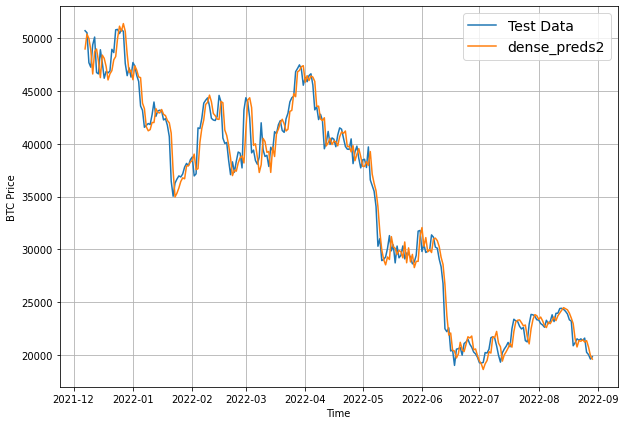

In [57]:
# Plot dense_preds2 vs test_labels
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=dense_preds2, start=offset, format="-", label="dense_preds2")

# Dense model (window = 30, horizon = 7)

In [58]:
# Predict a week at a time
WINDOW_SIZE = 30 # 30 days to predict next 7 days
HORIZON = 7 # predict a week

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2822, 2822)

In [59]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2257, 565, 2257, 565)

In [60]:
tf.random.set_seed(42)

# Create model
dense_nn3 = tf.keras.Sequential([
                layers.Dense(128, activation='relu'),
                layers.Dense(HORIZON),
            ], name="dense_nn3")

# Compile model
dense_nn3.compile(loss='MAE', optimizer='adam')

# Fit model
dense_nn3.fit(train_windows, train_labels, validation_data=(test_windows, test_labels), batch_size=128, epochs=100, verbose=0,
              callbacks=[model_checkpoint(model_name=dense_nn3.name)])

In [61]:
# Evaluate the model on the test set
dense_nn3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 2549.7214


2549.721435546875

In [62]:
# Load best version of dense_nn3 and evaluate on the test set
dense_nn3 = tf.keras.models.load_model('model_experiments/dense_nn3/')
dense_nn3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 2489.3259


2489.325927734375

In [63]:
# Make weekly predictions with dense_nn3
dense_preds3 = make_preds(dense_nn3, input_data=test_windows)
dense_preds3[:5]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[38124.336, 36869.67 , 36477.71 , 37854.32 , 38361.145, 37684.863,
        37185.887],
       [38942.184, 38453.043, 37206.016, 38387.773, 37817.887, 37672.633,
        38033.062],
       [38735.89 , 39380.98 , 38937.867, 38046.914, 38766.605, 39392.855,
        39370.145],
       [38998.21 , 38447.54 , 38719.95 , 39409.73 , 38794.12 , 38938.77 ,
        40098.13 ],
       [44814.12 , 43392.965, 43291.195, 43298.215, 44139.94 , 44026.844,
        43144.67 ]], dtype=float32)>

In [64]:
# View different prediction dimensions 
dense_preds3.shape, dense_preds2.shape, dense_preds.shape

(TensorShape([565, 7]), TensorShape([566]), TensorShape([571]))

In [65]:
# Evaluating dense_nn metrics one value for every value in test set (needs to be aggregated to one value as before))
dense_results_3 = calculate_metrics(y_true=tf.squeeze(test_labels), y_pred=dense_preds3)

##Create metrics for larger horizons
Larger horizons (7 days) require that  metrics are reduces to a single value.


In [66]:
def calculate_metrics(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32) # float32 for metric tensors 
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mean_absolute_scaled_error = mase(y_true, y_pred)

  # Account for different sized metrics (aggregated to one value)
  if mae.ndim > 0: # Scalars values have no dimentions, so reduce to the mean if greater than 0
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mean_absolute_scaled_error = tf.reduce_mean(mean_absolute_scaled_error)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mean_absolute_scaled_error.numpy()}

In [67]:
# Calculate dense_nn3 metrics
dense_results_3 = calculate_metrics(y_true=tf.squeeze(test_labels),y_pred=dense_preds3) # Squeeze predictions no longer required
dense_results_3

{'mae': 2489.3262,
 'mse': 11408685.0,
 'rmse': 2851.773,
 'mape': 6.061208,
 'mase': 2.1347284}

## Aggregate plot for larger horizons

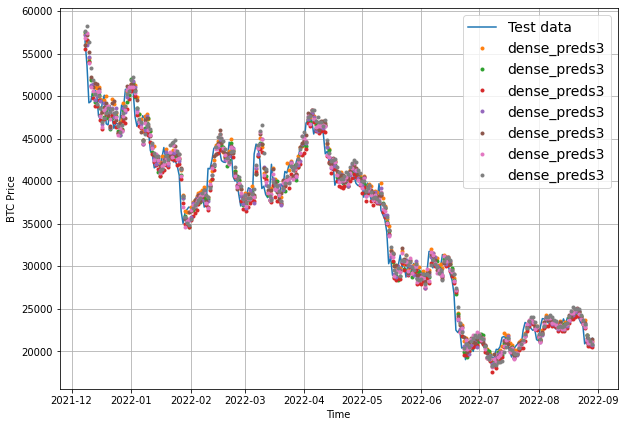

In [68]:
# dense_preds3 (non-aggregated) vs test_labels
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=dense_preds3, start=offset, label="dense_preds3")

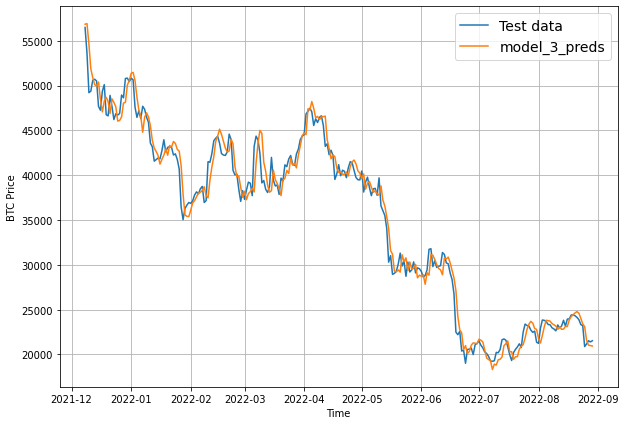

In [69]:
# dense_preds3 (aggregated) vs test_labels
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 format="-",
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(dense_preds3, axis=1), # Aggregate preds from 7-day to singular value (NB: some information loss)
                 start=offset,
                 format="-", 
                 label="model_3_preds")

#Compare peformances

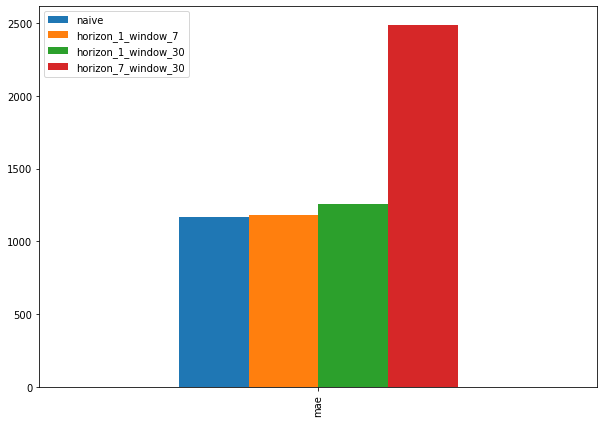

In [70]:
# dense_results_3 underperforms quite a bit, since we predict 7 steps at a time
pd.DataFrame({'naive': naive_results['mae'],
              'horizon_1_window_7': dense_results['mae'],
              'horizon_1_window_30': dense_results_2['mae'], 
              'horizon_7_window_30': dense_results_3['mae']}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

#CNN model (Convolutional Neural Networks)

In [71]:
HORIZON = 1
WINDOW_SIZE = 7 

In [72]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2851, 2851)

In [73]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2280, 571, 2280, 571)

##Expand dimentions for CNNs

In [74]:
# A Conv1D layer expects an input shape of (batch_size, timesteps, input_dim)
train_windows[0].shape # Current shape (WINDOW_SIZE, )

(7,)

In [75]:
# Reshape the Conv1D layer input into a tensor
x = tf.constant(train_windows[0]) 
x 

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([325.891998, 327.553986, 330.492004, 339.485992, 349.290009,
       342.415009, 345.488007])>

In [76]:
# Expand input shape from (7,) to (7,1) using lambda as layer input to Conv1D model
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) 

In [77]:
# View lambda layer impact
print(f'Original shape: {x.shape}') # (WINDOW_SIZE)
print(f'Expanded shape: {expand_dims_layer(x).shape}') # (WINDOW_SIZE, input_dim)
print(f'Original values with expanded shape:\n {expand_dims_layer(x)}') # Insert every day in its own tensor

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[325.892]
 [327.554]
 [330.492]
 [339.486]
 [349.29 ]
 [342.415]
 [345.488]]


In [78]:
tf.random.set_seed(42)

# Create the model
cnn_model = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),# Reshape inputs
  layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='causal', activation='relu'), # 128 windows of size 5 (days)
  layers.Dense(HORIZON),                      
  ], name="cnn_model")

# Compile the model
cnn_model.compile(loss='mae', optimizer='adam')

# Fit the model
cnn_model.fit(train_windows, train_labels, batch_size=128, epochs=100, verbose=1, validation_data=(test_windows, test_labels),
              callbacks=[model_checkpoint(model_name=cnn_model.name)]) 

Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 2274.1052  

18/18 [==============================] - 7s 45ms/step - loss: 2090.7446 - val_loss: 5865.8022
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 538.1779

18/18 [==============================] - 1s 38ms/step - loss: 534.1818 - val_loss: 2404.0974
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 314.6591

18/18 [==============================] - 1s 36ms/step - loss: 314.6591 - val_loss: 2156.5845
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 339.8351

18/18 [==============================] - 1s 35ms/step - loss: 293.5601 - val_loss: 1958.9829
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 278.3661

18/18 [==============================] - 1s 35ms/step - loss: 278.3661 - val_loss: 1940.6274
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 274.9640 - val_loss: 1964.9061
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 277.6202

18/18 [==============================] - 1s 34ms/step - loss: 271.4056 - val_loss: 1874.0850
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 259.4663

18/18 [==============================] - 1s 34ms/step - loss: 267.8188 - val_loss: 1868.0276
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 214.1704

18/18 [==============================] - 1s 34ms/step - loss: 262.5856 - val_loss: 1803.2322
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 261.9146 - val_loss: 1898.7991
Epoch 11/100
16/18 [=========================>....] - ETA: 0s - loss: 261.7448

18/18 [==============================] - 1s 36ms/step - loss: 255.0854 - val_loss: 1743.6440
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 189.2926

18/18 [==============================] - 1s 49ms/step - loss: 247.1125 - val_loss: 1711.6498
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 240.8654 - val_loss: 1716.1975
Epoch 14/100
18/18 [==============================] - ETA: 0s - loss: 235.0560

18/18 [==============================] - 1s 36ms/step - loss: 235.0560 - val_loss: 1650.4413
Epoch 15/100
18/18 [==============================] - 0s 4ms/step - loss: 230.2149 - val_loss: 1711.8583
Epoch 16/100
17/18 [===========================>..] - ETA: 0s - loss: 230.7420

18/18 [==============================] - 1s 36ms/step - loss: 233.0967 - val_loss: 1630.4263
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 182.6890

18/18 [==============================] - 1s 35ms/step - loss: 222.6035 - val_loss: 1554.8218
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 218.6824

18/18 [==============================] - 1s 35ms/step - loss: 216.7121 - val_loss: 1527.7849
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 211.5737 - val_loss: 1566.9806
Epoch 20/100
16/18 [=========================>....] - ETA: 0s - loss: 217.2977

18/18 [==============================] - 1s 35ms/step - loss: 218.5879 - val_loss: 1485.8995
Epoch 21/100
16/18 [=========================>....] - ETA: 0s - loss: 206.9817

18/18 [==============================] - 1s 37ms/step - loss: 204.4559 - val_loss: 1456.3213
Epoch 22/100
18/18 [==============================] - ETA: 0s - loss: 201.0760

18/18 [==============================] - 1s 35ms/step - loss: 201.0760 - val_loss: 1447.9169
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 200.7319 - val_loss: 1521.5271
Epoch 24/100
18/18 [==============================] - 0s 5ms/step - loss: 195.2191 - val_loss: 1578.4861
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 166.7767

18/18 [==============================] - 1s 35ms/step - loss: 195.1730 - val_loss: 1376.4849
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 137.5489

18/18 [==============================] - 1s 35ms/step - loss: 190.8842 - val_loss: 1372.1384
Epoch 27/100
18/18 [==============================] - ETA: 0s - loss: 191.6012

18/18 [==============================] - 1s 35ms/step - loss: 191.6012 - val_loss: 1363.5573
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 179.6791

18/18 [==============================] - 1s 51ms/step - loss: 187.2002 - val_loss: 1344.7888
Epoch 29/100
18/18 [==============================] - ETA: 0s - loss: 184.2800

18/18 [==============================] - 1s 35ms/step - loss: 184.2800 - val_loss: 1330.4739
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 172.1594

18/18 [==============================] - 1s 35ms/step - loss: 183.4281 - val_loss: 1329.1687
Epoch 31/100
18/18 [==============================] - ETA: 0s - loss: 185.7298

18/18 [==============================] - 1s 36ms/step - loss: 185.7298 - val_loss: 1317.8739
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 181.8740 - val_loss: 1335.6198
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 186.4170 - val_loss: 1353.7764
Epoch 34/100
18/18 [==============================] - ETA: 0s - loss: 192.9702

18/18 [==============================] - 1s 36ms/step - loss: 192.9702 - val_loss: 1296.6230
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 187.9214 - val_loss: 1366.1235
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 183.5666 - val_loss: 1303.8813
Epoch 37/100
18/18 [==============================] - 0s 4ms/step - loss: 180.7545 - val_loss: 1327.9689
Epoch 38/100
18/18 [==============================] - ETA: 0s - loss: 178.1905

18/18 [==============================] - 1s 35ms/step - loss: 178.1905 - val_loss: 1288.0464
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 186.9756 - val_loss: 1392.1272
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 226.2471

18/18 [==============================] - 1s 34ms/step - loss: 182.7169 - val_loss: 1281.4517
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 144.4591

18/18 [==============================] - 1s 36ms/step - loss: 177.5046 - val_loss: 1270.3705
Epoch 42/100
18/18 [==============================] - ETA: 0s - loss: 177.4755

18/18 [==============================] - 1s 35ms/step - loss: 177.4755 - val_loss: 1266.3831
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 176.2264 - val_loss: 1272.2610
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 169.7193

18/18 [==============================] - 1s 35ms/step - loss: 180.1278 - val_loss: 1262.0051
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 174.2058 - val_loss: 1401.6288
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 186.5182

18/18 [==============================] - 1s 34ms/step - loss: 178.8552 - val_loss: 1256.4948
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 176.4853 - val_loss: 1265.3447
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 177.2527 - val_loss: 1437.3007
Epoch 49/100
18/18 [==============================] - ETA: 0s - loss: 176.9122

18/18 [==============================] - 1s 35ms/step - loss: 176.9122 - val_loss: 1254.6611
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 172.5371 - val_loss: 1264.2483
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 179.3954 - val_loss: 1458.7572
Epoch 52/100
18/18 [==============================] - ETA: 0s - loss: 185.3537

18/18 [==============================] - 1s 51ms/step - loss: 185.3537 - val_loss: 1240.5740
Epoch 53/100
18/18 [==============================] - ETA: 0s - loss: 174.4966

18/18 [==============================] - 1s 35ms/step - loss: 174.4966 - val_loss: 1238.1384
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 172.4403 - val_loss: 1242.0797
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 170.4596 - val_loss: 1252.8444
Epoch 56/100
 1/18 [>.............................] - ETA: 0s - loss: 175.6857

18/18 [==============================] - 1s 36ms/step - loss: 169.3138 - val_loss: 1228.8864
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 182.0022 - val_loss: 1385.0703
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 192.5029 - val_loss: 1384.4219
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 177.3311 - val_loss: 1358.9476
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 187.3620 - val_loss: 1229.2030
Epoch 61/100
18/18 [==============================] - ETA: 0s - loss: 174.2530

18/18 [==============================] - 1s 36ms/step - loss: 174.2530 - val_loss: 1224.5950
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 171.9140 - val_loss: 1229.7074
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 168.4223 - val_loss: 1238.5918
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 169.3143 - val_loss: 1232.0172
Epoch 65/100
18/18 [==============================] - 0s 6ms/step - loss: 170.2384 - val_loss: 1437.0120
Epoch 66/100
18/18 [==============================] - ETA: 0s - loss: 176.8057

18/18 [==============================] - 1s 37ms/step - loss: 176.8057 - val_loss: 1218.3762
Epoch 67/100
 1/18 [>.............................] - ETA: 0s - loss: 189.9640

18/18 [==============================] - 1s 37ms/step - loss: 169.1297 - val_loss: 1214.6821
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 171.1526 - val_loss: 1325.1224
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 176.0435 - val_loss: 1216.9507
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 176.4672 - val_loss: 1258.5535
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 174.2126 - val_loss: 1224.2538
Epoch 72/100
18/18 [==============================] - 0s 4ms/step - loss: 169.7948 - val_loss: 1271.4113
Epoch 73/100
16/18 [=========================>....] - ETA: 0s - loss: 166.0665

18/18 [==============================] - 1s 38ms/step - loss: 168.1491 - val_loss: 1203.4913
Epoch 74/100
18/18 [==============================] - 0s 4ms/step - loss: 167.5135 - val_loss: 1331.5365
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 177.6600 - val_loss: 1216.0344
Epoch 76/100
18/18 [==============================] - 0s 4ms/step - loss: 169.3075 - val_loss: 1305.2643
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 172.6148 - val_loss: 1236.9905
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 167.1101 - val_loss: 1229.1212
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 170.1985 - val_loss: 1276.5835
Epoch 80/100
18/18 [==============================] - 0s 6ms/step - loss: 169.8786 - val_loss: 1346.9697
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 183.4565 - val_loss: 1466.3896
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - los

18/18 [==============================] - 1s 39ms/step - loss: 178.7568 - val_loss: 1195.4888
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 169.7565 - val_loss: 1200.4938
Epoch 84/100
18/18 [==============================] - 0s 4ms/step - loss: 173.1967 - val_loss: 1212.1345
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 173.1113 - val_loss: 1219.7147
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 171.0689 - val_loss: 1220.3959
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 179.6669 - val_loss: 1560.9662
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 176.0033 - val_loss: 1262.5197
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 169.5208 - val_loss: 1282.1035
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 171.5229 - val_loss: 1215.5948
Epoch 91/100
18/18 [==============================] - 0s 7ms/step -

18/18 [==============================] - 1s 52ms/step - loss: 170.7314 - val_loss: 1191.6821
Epoch 93/100
12/18 [===================>..........] - ETA: 0s - loss: 158.1646

18/18 [==============================] - 1s 44ms/step - loss: 166.3219 - val_loss: 1189.8407
Epoch 94/100
18/18 [==============================] - 0s 4ms/step - loss: 165.9556 - val_loss: 1200.8132
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 164.7600 - val_loss: 1217.9945
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 168.2242 - val_loss: 1196.3776
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 167.9437 - val_loss: 1250.4758
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 166.6153 - val_loss: 1265.8798
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 171.8802 - val_loss: 1200.4336
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 164.9589 - val_loss: 1333.4675


In [79]:
# View summary
cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Load in best performing Conv1D and re-evaluate
cnn_model = tf.keras.models.load_model("model_experiments/cnn_model")
cnn_model.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 1189.8406


1189.840576171875

In [81]:
# Make predictions
cnn_preds = make_preds(cnn_model, test_windows)
cnn_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([37156.72 , 38058.69 , 39333.38 , 39264.03 , 44964.938, 46861.227,
       45613.9  , 47614.594, 48150.062, 47508.85 ], dtype=float32)>

In [82]:
test_labels.shape, cnn_preds.shape

((571, 1), TensorShape([571]))

In [83]:
# calculate metrics
cnn_results = calculate_metrics(y_true=tf.squeeze(test_labels), y_pred=cnn_preds)
cnn_results

{'mae': 1189.8407,
 'mse': 2770646.0,
 'rmse': 1664.5258,
 'mape': 2.8668313,
 'mase': 1.0193467}

#LSTM model (long short-term memory)

In [84]:
tf.random.set_seed(42)

# Build an LSTM model with Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation='relu', return_sequences=True)(x)
x = layers.LSTM(128, activation='relu')(x)
output = layers.Dense(HORIZON)(x)
LSTM_model = tf.keras.Model(inputs, output, name="LSTM_model")

# Compile
LSTM_model.compile(loss='mae', optimizer='adam')

# Fit
LSTM_model.fit(train_windows, train_labels, batch_size=128, epochs=100, verbose=1, validation_data=(test_windows, test_labels),
               callbacks=[model_checkpoint(model_name=LSTM_model.name)])

Epoch 1/100
18/18 [==============================] - 5s 180ms/step - loss: 4569.1611 - val_loss: 22838.7812
Epoch 2/100
18/18 [==============================] - 3s 177ms/step - loss: 1345.9550 - val_loss: 5349.7153
Epoch 3/100
18/18 [==============================] - 3s 166ms/step - loss: 377.6896 - val_loss: 2534.9246
Epoch 4/100
18/18 [==============================] - 3s 167ms/step - loss: 283.1965 - val_loss: 1941.3927
Epoch 5/100
18/18 [==============================] - 0s 10ms/step - loss: 268.0753 - val_loss: 2307.2161
Epoch 6/100
18/18 [==============================] - 3s 181ms/step - loss: 265.2214 - val_loss: 1810.2933
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 261.6973 - val_loss: 1844.6478
Epoch 8/100
18/18 [==============================] - 0s 9ms/step - loss: 262.2986 - val_loss: 1866.3958
Epoch 9/100
18/18 [==============================] - 0s 9ms/step - loss: 259.7825 - val_loss: 1815.5697
Epoch 10/100
18/18 [==============================

In [85]:
# Load in best version of LSTM_model and evaluate on the test set
LSTM_model = tf.keras.models.load_model("model_experiments/LSTM_model")
LSTM_model.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1208.9602


1208.960205078125

In [86]:
# Make predictions 
LSTM_preds = make_preds(LSTM_model, test_windows)
LSTM_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([37075.45 , 37941.773, 39229.26 , 39173.727, 44549.598],
      dtype=float32)>

In [87]:
# Calculate metrics
LSTM_results = calculate_metrics(y_true=tf.squeeze(test_labels), y_pred=LSTM_preds)
LSTM_results

{'mae': 1208.9602,
 'mse': 2789970.8,
 'rmse': 1670.3206,
 'mape': 2.9053125,
 'mase': 1.0357265}

#Multivariate time series wit block reward

In [88]:
# Univariate data 
bitcoin_prices.head()

,Price
Date,
2014-11-02,325.891998
2014-11-03,327.553986
2014-11-04,330.492004
2014-11-05,339.485992
2014-11-06,349.290009


In [89]:
# Add Bitcoin halving 
block_reward_1 = 50 # 3 January 2009 - will not be in dataset (before halving)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020 - last halving date until 2024

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09") 
block_reward_4_datetime = np.datetime64("2020-05-18") 

In [90]:
# Date ranges for block_reward values
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days 
block_reward_2_days, block_reward_3_days

(615, 2024)

In [91]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2 # iloc to index on  ranges, -1 to fill last column
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [92]:
# 2858 entries
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2858 entries, 2014-11-02 to 2022-08-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2858 non-null   float64
 1   High       2858 non-null   float64
 2   Low        2858 non-null   float64
 3   Close      2858 non-null   float64
 4   Adj Close  2858 non-null   float64
 5   Volume     2858 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 156.3 KB


In [93]:
# View dataframe
bitcoin_prices_block.iloc[2700:2800]

,Price,block_reward
Date,,
2022-03-25,44348.730469,6.25
2022-03-26,44500.828125,6.25
2022-03-27,46820.492188,6.25
2022-03-28,47128.003906,6.25
2022-03-29,47465.730469,6.25
...,...,...
2022-06-28,20280.634766,6.25
2022-06-29,20104.023438,6.25
2022-06-30,19784.726563,6.25


In [94]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-11-02,325.891998,25
2014-11-03,327.553986,25
2014-11-04,330.492004,25
2014-11-05,339.485992,25
2014-11-06,349.290009,25


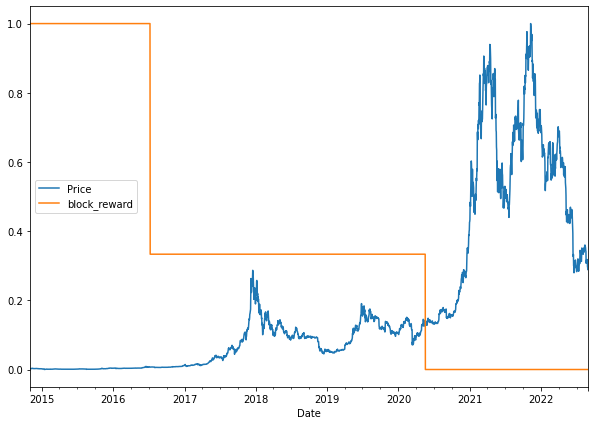

In [95]:
# Plot block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # Adjust scales
                                                                       columns=bitcoin_prices_block.columns,
                                                                       index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

##Make windowed dataset for multivariate series

In [96]:
# Setup hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [97]:
# Copy the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f'Price {i+1}']=bitcoin_prices_windowed['Price'].shift(periods=i+1)# Shift prices by 1
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price 1,Price 2,Price 3,Price 4,Price 5,Price 6,Price 7
Date,,,,,,,,,
2014-11-02,325.891998,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-03,327.553986,25,325.891998,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-04,330.492004,25,327.553986,325.891998,NaN,NaN,NaN,NaN,NaN
2014-11-05,339.485992,25,330.492004,327.553986,325.891998,NaN,NaN,NaN,NaN
2014-11-06,349.290009,25,339.485992,330.492004,327.553986,325.891998,NaN,NaN,NaN
2014-11-07,342.415009,25,349.290009,339.485992,330.492004,327.553986,325.891998,NaN,NaN
2014-11-08,345.488007,25,342.415009,349.290009,339.485992,330.492004,327.553986,325.891998,NaN
2014-11-09,363.264008,25,345.488007,342.415009,349.290009,339.485992,330.492004,327.553986,325.891998
2014-11-10,366.924011,25,363.264008,345.488007,342.415009,349.290009,339.485992,330.492004,327.553986


In [98]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price 1,Price 2,Price 3,Price 4,Price 5,Price 6,Price 7
Date,,,,,,,,,
2022-08-25,21600.904297,6.25,21395.019531,21528.087891,21398.908203,21534.121094,21166.060547,20877.552734,23212.738281
2022-08-26,20260.019531,6.25,21600.904297,21395.019531,21528.087891,21398.908203,21534.121094,21166.060547,20877.552734
2022-08-27,20041.738281,6.25,20260.019531,21600.904297,21395.019531,21528.087891,21398.908203,21534.121094,21166.060547
2022-08-28,19616.814453,6.25,20041.738281,20260.019531,21600.904297,21395.019531,21528.087891,21398.908203,21534.121094
2022-08-29,19835.164063,6.25,19616.814453,20041.738281,20260.019531,21600.904297,21395.019531,21528.087891,21398.908203


In [99]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)
X.head()

,block_reward,Price 1,Price 2,Price 3,Price 4,Price 5,Price 6,Price 7
Date,,,,,,,,
2014-11-09,25.0,345.488007,342.415009,349.290009,339.485992,330.492004,327.553986,325.891998
2014-11-10,25.0,363.264008,345.488007,342.415009,349.290009,339.485992,330.492004,327.553986
2014-11-11,25.0,366.924011,363.264008,345.488007,342.415009,349.290009,339.485992,330.492004
2014-11-12,25.0,367.695007,366.924011,363.264008,345.488007,342.415009,349.290009,339.485992
2014-11-13,25.0,423.561005,367.695007,366.924011,363.264008,345.488007,342.415009,349.290009


In [100]:
y.head()

Date
2014-11-09    363.264008
2014-11-10    366.924011
2014-11-11    367.695007
2014-11-12    423.561005
2014-11-13    420.734985
Name: Price, dtype: float32

In [101]:
# Make train and test sets
split_size = int(0.8*len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2280, 2280, 571, 571)

# Dense Model (multivariate)

In [102]:
tf.random.set_seed(42)

# Build multivariate model
dense_multi = tf.keras.Sequential([
                   layers.Dense(128, activation='relu'),
                   layers.Dense(HORIZON)], 
                   name="dense_multi")

# Compile
dense_multi.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())

# Fit
dense_multi.fit(X_train, y_train, epochs=100, batch_size=128, verbose=1, validation_data=(X_test, y_test),
                callbacks=[model_checkpoint(model_name=dense_multi.name)])

Epoch 1/100
18/18 [==============================] - 1s 30ms/step - loss: 2154.9290 - val_loss: 5015.6553
Epoch 2/100
18/18 [==============================] - 0s 25ms/step - loss: 555.2951 - val_loss: 2916.6492
Epoch 3/100
18/18 [==============================] - 0s 26ms/step - loss: 364.9782 - val_loss: 2333.1228
Epoch 4/100
18/18 [==============================] - 1s 41ms/step - loss: 328.8130 - val_loss: 2181.6912
Epoch 5/100
18/18 [==============================] - 0s 24ms/step - loss: 306.6655 - val_loss: 2100.1174
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 297.4447 - val_loss: 2113.0581
Epoch 7/100
18/18 [==============================] - 0s 23ms/step - loss: 292.3809 - val_loss: 1996.3082
Epoch 8/100
18/18 [==============================] - 0s 25ms/step - loss: 284.7094 - val_loss: 1970.5061
Epoch 9/100
18/18 [==============================] - 0s 24ms/step - loss: 278.9638 - val_loss: 1901.9766
Epoch 10/100
18/18 [==============================] - 0

In [103]:
# Load in and evaluate best performing model
dense_multi = tf.keras.models.load_model("model_experiments/dense_multi")
dense_multi.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 1181.1346


1181.1346435546875

In [104]:
# Make predictions with multivariate model
dense_multi_preds = tf.squeeze(dense_multi.predict(X_test))
dense_multi_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([37032.586, 38137.406, 39437.566, 39078.914, 45336.273, 46631.293,
       44906.926, 47931.793, 48066.28 , 47091.45 ], dtype=float32)>

In [105]:
# Calculate metrics
dense_multi_results = calculate_metrics(y_true=y_test, y_pred=dense_multi_preds)
dense_multi_results

{'mae': 1181.1346,
 'mse': 2728008.2,
 'rmse': 1651.6683,
 'mape': 2.8375478,
 'mase': 1.0118881}

In [106]:
# Recall naive results
naive_results

{'mae': 1167.3472,
 'mse': 2708600.8,
 'rmse': 1645.7827,
 'mape': 2.7939985,
 'mase': 1.0000763}

# N-BEATS algorithm model

Replicates the algorithm in Figure 1 from the N-BEATS paper (see t.ly/aqS-)

In [ ]:
# Create an N-BEATS block custom layer instance (not amodel yet)
class NBeatsBlock(tf.keras.layers.Layer): # Parent class with subclass keras 'Layer' to create custom layers
  def __init__(self, # The constructor takes in all layer hyperparameters
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # The **kwargs argument handles all parent class arguments  (input_shape, trainable, name)
    super().__init__(**kwargs) 
    self.input_size = input_size # Layer hyper parameters initialized in constructor
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stacks of 4 fully connected layers with ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)] # For loop returns a list
    # Block output is a theta layer with linear activation, so no activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta') # Theta sized hidden units

  # Runs when the layer is called
  def call(self, inputs): # Describes layer functions from inputs (lookback period) to outputs (backcast + forecast)
    x = inputs # Replicate inputs
    for layer in self.hidden: # Pass inputs through each hidden layer 
      x = layer(x) # Continually update x, as it passes through each step of dense stack
    theta = self.theta_layer(x) # Pass x through theta
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)# nn layers get istantiated with random weights
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, # input = lookback window/period
                                       theta_size=WINDOW_SIZE+HORIZON, # theta = backcast + forecast
                                       horizon=HORIZON, 
                                       n_neurons=128, 
                                       n_layers=4) # 4 layers from paper                                       

In [ ]:
# Create dummy inputs to have the same size as input_size
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # The input shape has to reflect the dense layer requirements of 2 dims
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# The activation outputs of the theta layer
print(f'Backcast:{tf.squeeze(backcast).numpy()}')
print(f'Forecast:{tf.squeeze(forecast).numpy()}')

Backcast:[ 0.07960171  0.32512033 -0.8428683  -0.6938985  -0.31720552 -0.5698734
 -0.6396662 ]
Forecast:1.0071648359298706


##Preprocess data for the N-BEATS algorithm using tf.data

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop('Price', axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']#

# Make train and test sets
split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
# Using tf.data API for performance
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features to tupples (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

##N-BEATS hyperparameters
Can be found in paper's Table 18

In [ ]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4 
N_STACKS = 30 # layers->blocks->stacks

INPUT_SIZE = WINDOW_SIZE * HORIZON # Multiple of lookbacks from paper
THETA_SIZE = INPUT_SIZE + HORIZON # Theta outputs backcast/lookbacks and forecast

INPUT_SIZE, THETA_SIZE

(7, 8)

##Preparing Residual neural network
The residual connections (subtract and add) of paper's section 3.2.

In [ ]:
# Create tensors (dummy version)
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract connection
subtracted = layers.subtract([tensor_1, tensor_2])

# Add connection
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f'Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}')
print(f'Subtracted: {subtracted.numpy()}')
print(f'Added: {added.numpy()}')

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


##Build the N-BEATS algorithm model

In [ ]:
%%time
tf.random.set_seed(42)

# Instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, # Inputs
                                 theta_size=WINDOW_SIZE + HORIZON, # Hidden units
                                 horizon=HORIZON,# Forecast
                                 n_neurons=N_NEURONS, # Nmber of units
                                 n_layers=N_LAYERS, # Nmber of layers
                                 name="InitialBlock") # **kwargs allows for the use of named parameters

# Input to stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# Initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input) 

# Stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # First stack is already created above, ergo '-1'

  # Use NBeatsBlock to calculate the backcast and forecast
  backcast, block_forecast = NBeatsBlock(input_size=WINDOW_SIZE,  
                                         theta_size=WINDOW_SIZE + HORIZON, 
                                         horizon=HORIZON, 
                                         n_neurons= N_NEURONS,
                                         n_layers=N_LAYERS,
                                         # Pass residuals, i.e observations-fitted values (leftovers are later subtracted from the backcast) 
                                         name= f"NBeatsBlock_{i}")(residuals)

  # The double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")# Subtracts from itself and backcast
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")# Adds to original forecast

# The stack model
NBEATS_model = tf.keras.Model(stack_input, forecast, name="NBEATS_model")

# Compile the model
NBEATS_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())

# Fit the model with callbacks
NBEATS_model.fit(train_dataset, validation_data=test_dataset, epochs=N_EPOCHS, verbose=0,
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)])


Epoch 922: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1022: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 3min 6s, sys: 5.11 s, total: 3min 11s
Wall time: 4min 11s


In [ ]:
# Evaluate N-BEats model on the test set
NBEATS_model.evaluate(test_dataset)

1/1 [==============================] - 0s 22ms/step - loss: 574.5956


574.5956420898438

In [ ]:
# Make predictions with N-BEATS model
NBEATS_preds = make_preds(NBEATS_model, test_dataset)
NBEATS_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8886.861, 8798.209, 9027.715, 8804.99 , 8761.575, 8745.931,
       8689.257, 8528.587, 8484.316, 8525.484], dtype=float32)>

In [ ]:
# Calculate metrics
NBEATS_results = calculate_metrics(y_true=y_test, y_pred=NBEATS_preds)
NBEATS_results

{'mae': 574.59564,
 'mse': 1185656.6,
 'rmse': 1088.8785,
 'mape': 2.5788722,
 'mase': 1.0094054}

In [ ]:
# Recall dense_results
dense_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [ ]:
# Recall naive results
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

##View the N-BEATS architecture with plot_model

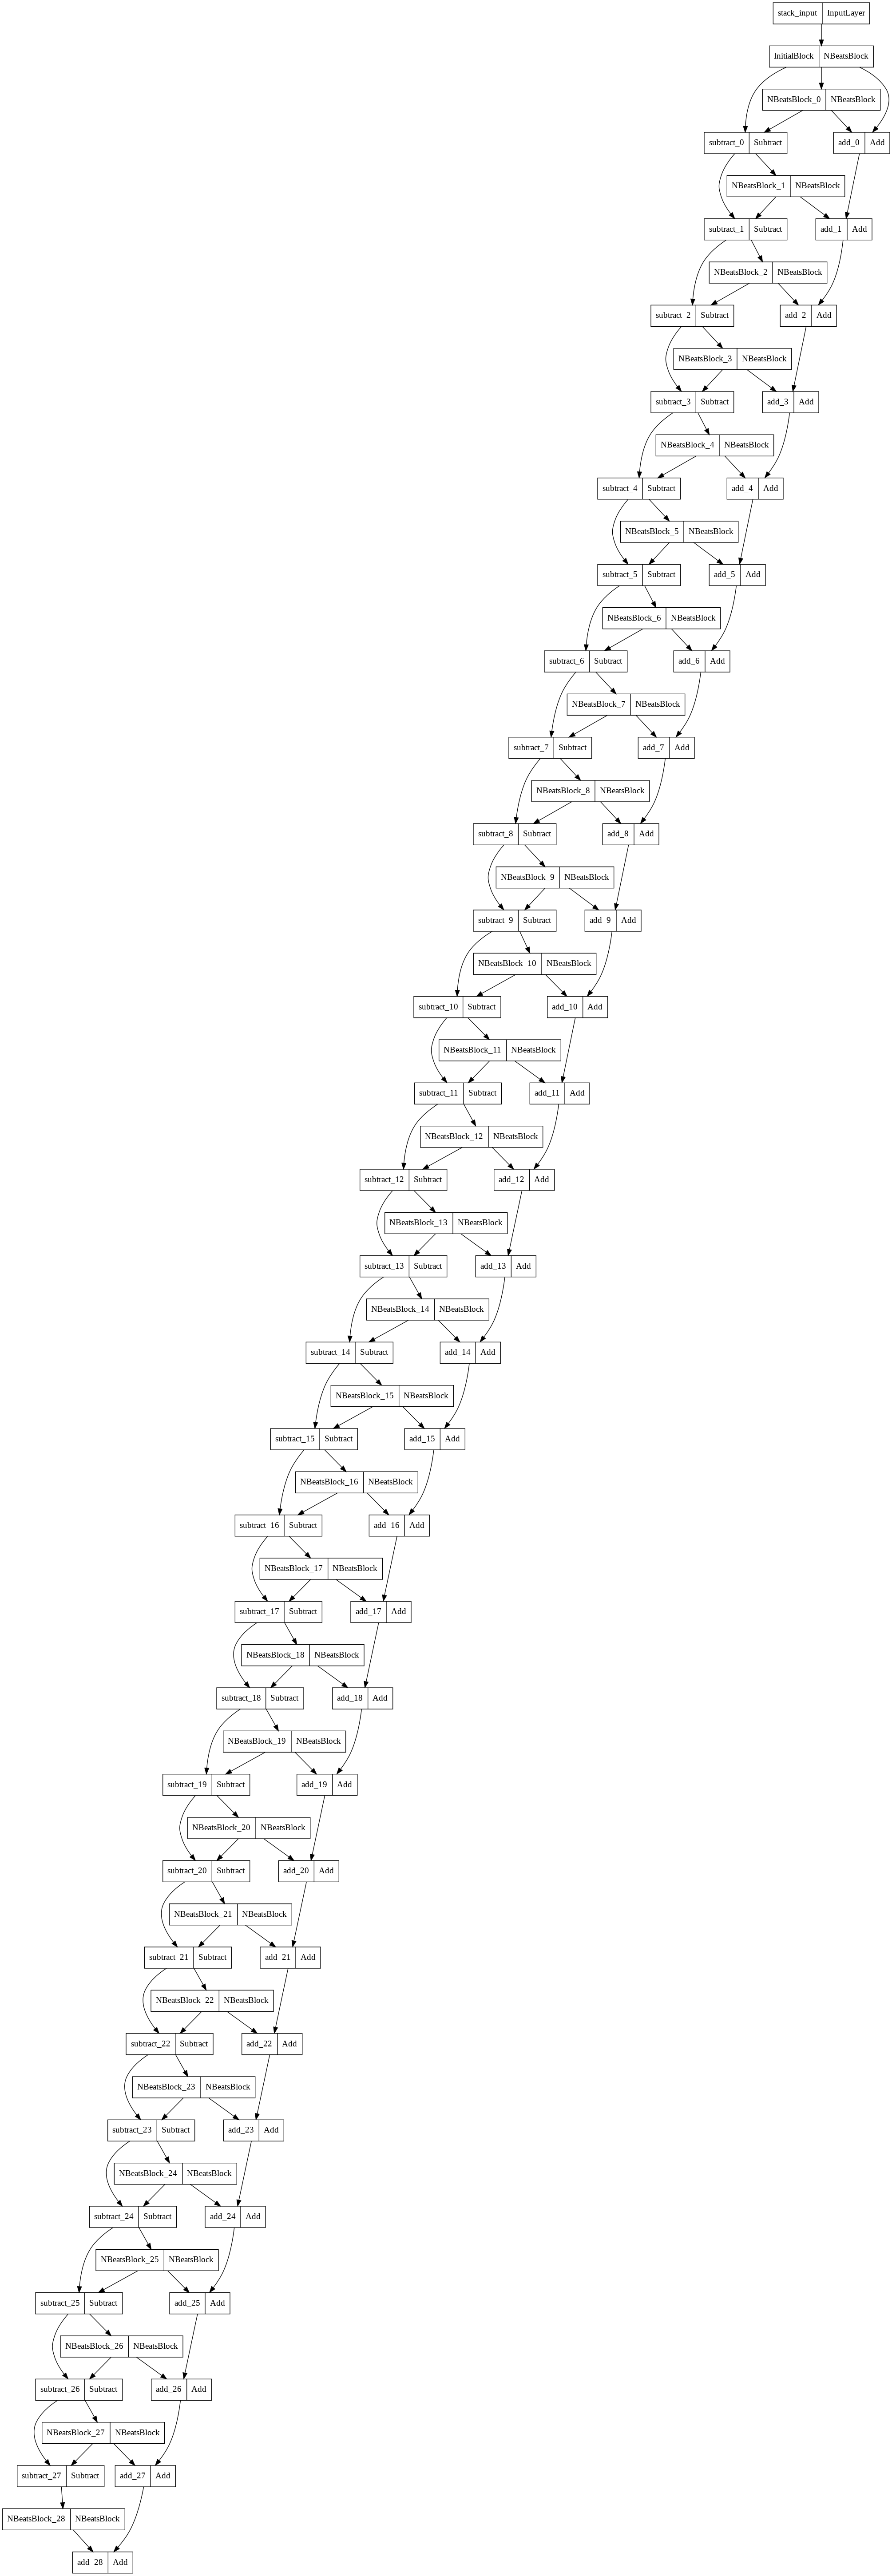

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(NBEATS_model)

#Ensemble model (stacking models together)

In [ ]:
def ensemble_model(input_size=WINDOW_SIZE,
                   theta_size=WINDOW_SIZE+HORIZON,
                   horizon=HORIZON,
                   num_iter=10, # Number of different models to train per loss function
                   num_epochs=1000, # Epochs per model 
                   loss_fns=["mae", "mse", "mape"]): # List of each from 10 models loss metrics, so 10*len(["mae", "mse", "mape"]) 
  
  # Empty list for trained ensemble
  ensemble_models = []

  # Loops through models to train per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns: # Nested loop through epochs
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Istantiates a new model for every 'i' in 'num_iter' on architecture of simple dense model
      model = tf.keras.Sequential([
                # Initialize with normal distribution for later estimation of prediction intervals 
                layers.Dense(128, kernel_initializer="he_normal", activation='relu'), # he_normal assumed in 'uncertainty estimates' below
                layers.Dense(128, kernel_initializer="he_normal", activation='relu'), 
                layers.Dense(HORIZON)
                ])

      # Compile the model
      model.compile(loss=loss_function, optimizer='adam', metrics= ['mae', 'mse'])
      
      # Fit the model
      model.fit(train_dataset, validation_data=test_dataset, epochs=N_EPOCHS, verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True), 
                           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)]
      )                                                 
      # Append fitted model to ensemble list 
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
%%time
# Create list of trained ensemble models
ensemble_models = ensemble_model(num_iter=5, num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 1000: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1118: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1218: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 585: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 700: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 800: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 168: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 268: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 913: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1

##Create ensemble model predictions

In [ ]:
len(ensemble_models)

15

In [ ]:
# Function takes a list of trained models and return a list of predictions
def ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models: # For-loops may slow down training
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
%%time
# List of ensemble predictions
ensemble_preds = ensemble_preds(ensemble_models=ensemble_models, data=test_dataset)
ensemble_preds

CPU times: user 707 ms, sys: 23 ms, total: 730 ms
Wall time: 974 ms


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8791.772 ,  8795.833 ,  9060.939 , ..., 50319.113 , 49616.19  ,
        46511.438 ],
       [ 8761.89  ,  8737.598 ,  9049.424 , ..., 49309.008 , 48526.516 ,
        45319.1   ],
       [ 8745.424 ,  8733.034 ,  9101.386 , ..., 49267.164 , 47660.426 ,
        45370.047 ],
       ...,
       [ 8884.328 ,  8764.308 ,  9056.758 , ..., 48989.332 , 49540.086 ,
        46010.6   ],
       [ 8724.085 ,  8801.785 ,  9098.35  , ..., 49558.86  , 48504.016 ,
        45035.355 ],
       [ 8817.503 ,  8762.021 ,  9041.3545, ..., 49726.348 , 48060.637 ,
        45835.07  ]], dtype=float32)>

In [ ]:
# 15 models making 556 predictions on same data
ensemble_preds[:10]  

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8791.772 ,  8795.833 ,  9060.939 , ..., 50319.113 , 49616.19  ,
        46511.438 ],
       [ 8761.89  ,  8737.598 ,  9049.424 , ..., 49309.008 , 48526.516 ,
        45319.1   ],
       [ 8745.424 ,  8733.034 ,  9101.386 , ..., 49267.164 , 47660.426 ,
        45370.047 ],
       ...,
       [ 8884.328 ,  8764.308 ,  9056.758 , ..., 48989.332 , 49540.086 ,
        46010.6   ],
       [ 8724.085 ,  8801.785 ,  9098.35  , ..., 49558.86  , 48504.016 ,
        45035.355 ],
       [ 8817.503 ,  8762.021 ,  9041.3545, ..., 49726.348 , 48060.637 ,
        45835.07  ]], dtype=float32)>

In [ ]:
# Mean value of 15 different models
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10] 

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8791.791, 8779.661, 9063.779, 8730.78 , 8746.572, 8718.217,
       8664.154, 8482.836, 8458.838, 8527.005], dtype=float32)>

In [ ]:
# Medean value of 15 different models
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([8791.942, 8777.582, 9060.626, 8719.779, 8744.229, 8725.206,
       8661.52 , 8480.794, 8455.919, 8528.555], dtype=float32)

In [ ]:
# Evaluate ensemble model predictions from mean value
ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_mean)
ensemble_results

{'mae': 566.1226,
 'mse': 1141645.6,
 'rmse': 1068.4781,
 'mape': 2.5792909,
 'mase': 0.99452066}

In [ ]:
# Evaluate ensemble model predictions  from median value
ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_median)
ensemble_results

{'mae': 566.7758,
 'mse': 1147323.5,
 'rmse': 1071.1318,
 'mape': 2.5830615,
 'mase': 0.9956681}

In [ ]:
# Recall dense_results
dense_results

{'mae': 568.95105,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.9994894}

## Plot prediction intervals/uncertainty estimates
Making prediction ranges of 95% confidence prediction intervals rather than point predictions

In [ ]:
# Find upper and lower bounds of ensemble predictions assuming a normal distribution 
def get_pred_bounds(preds): # Take the predictions from a number of randomly intialized models

  # Measure the standard deviation
  std = tf.math.reduce_std(preds, axis=0)

  # Multiply by the 97.5th percentile point (1.96)
  interval = 1.96 * std

  # Get the prediction interval bounds 
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [ ]:
# Get bounds of 95% of the area prediction interval
lower, upper = get_pred_bounds(preds=ensemble_preds)

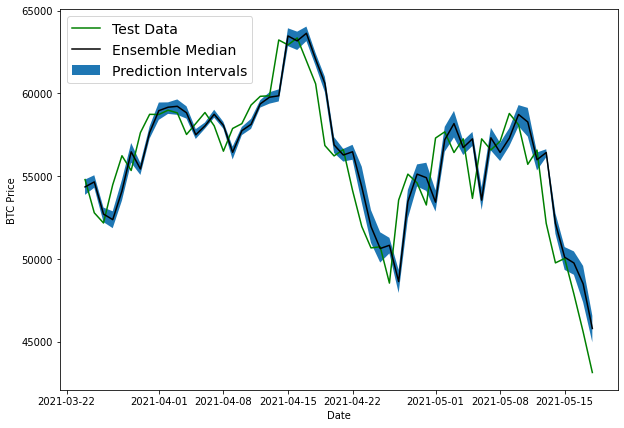

In [ ]:
# Get the median or mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median/mean of ensemble preds with prediction intervals
offset=500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# Plot upper and lower bounds with fill_between
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

# Forecast model 
Train a model on all data to make real forecasts. Above predictions are 'pseudo' forecasts, since the test set data is historical. 

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price 1,Price 2,Price 3,Price 4,Price 5,Price 6,Price 7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy() 
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [ ]:
X_all[:5], y_all[:5]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866]]),
 array([123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ]))

In [ ]:
# Turn data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

# Create simple dense model model
forecast_model = tf.keras.Sequential([
                    layers.Dense(128, activation='relu'),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(HORIZON)
                 ], name="forecast_model")

# Compile model
forecast_model.compile(loss=tf.keras.losses.mae, optimizer=tf.keras.optimizers.Adam())

# Fit model on all data 
forecast_model.fit(dataset_all, epochs=100, verbose=0)

##Create forecast function

In [ ]:
# Timesteps to predict
INTO_FUTURE = 14

In [ ]:
# Returns a list  
def create_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list: # '->': The function is not forced to return an integer
  
  # Empty list to forecast on
  forecast = []
  last_window = values[-WINDOW_SIZE:]

  # Get INTO_FUTURE number of predictions
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it, eventually making forecasts on its own forecasts
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to forecast list
    forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:] # Will append a lists of arrays to each other
  
  return forecast

In [ ]:
# Make forecasts
forecast_windows = create_forecasts(values=y_all, model=forecast_model, into_future=INTO_FUTURE, window_size=WINDOW_SIZE)

Predicting on:
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55764.47265625

Predicting on:
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55764.47265625] -> Prediction: 50985.9296875

Predicting on:
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55764.47265625 50985.9296875 ] -> Prediction: 48522.9609375

Predicting on:
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55764.47265625 50985.9296875  48522.9609375 ] -> Prediction: 48137.19921875

Predicting on:
 [47885.62525472 45604.61575361 43144.47129086 55764.47265625
 50985.9296875  48522.9609375  48137.19921875] -> Prediction: 47880.6328125

Predicting on:
 [45604.61575361 43144.47129086 55764.47265625 50985.9296875
 48522.9609375  48137.19921875 47880.6328125 ] -> Prediction: 46879.71484375

Predicting on:
 [43144.47129086 55764.47265625 50985.9296875  48522.960937